# Elementos de procesamiento de lenguajes naturales, o El Hacedor

Este texto está inspirado en [makemore](https://github.com/karpathy/makemore) de Andrej Karpathy. A continuación, crearemos un modelo de lenguaje basado en bigramas. Mediante 21,209 nombres argentinos, nuestro modelo aprenderá a formular nuevos nombres con estadísticas obtenidas de nuestros datos; después, lo optimizaremos con una red neuronal.

```{margin}
El conjunto de datos original se puede encontrar [aquí](https://www.kaggle.com/datasets/akielbowicz/nombres-de-personas-fsicas-de-argentina). El código que utilicé para limpiar los datos está comentado en la primera celda; el archivo generado con dicho código se encuentra [aquí](https://github.com/DanteNoguez/CalculusRatiocinator/blob/main/data/nombres.txt).
```

In [1]:
import pandas as pd
import numpy as np
import re

#nombres = pd.read_csv('historico-nombres.csv').iloc[0:200000]
#regex = "[^a-z]"
#nombres = nombres['nombre'].str.lower()
#filtro = nombres.str.contains("[^a-z]")
#nombres = nombres[~filtro].astype('str')

#nombres.to_csv(r'nombres.txt', header=None, index=None, mode='a')
#nombres.head(10)

In [2]:
!wget https://github.com/DanteNoguez/CalculusRatiocinator/raw/main/data/nombres.txt

--2022-10-19 16:36:19--  https://github.com/DanteNoguez/CalculusRatiocinator/raw/main/data/nombres.txt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DanteNoguez/CalculusRatiocinator/main/data/nombres.txt [following]
--2022-10-19 16:36:19--  https://raw.githubusercontent.com/DanteNoguez/CalculusRatiocinator/main/data/nombres.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165469 (162K) [text/plain]
Saving to: ‘nombres.txt’

nombres.txt         100%[===================>] 161.59K  --.-KB/s    in 0.02s   

2022-10-19 16:36:20 (10.1 MB/s) - ‘nombres.txt’ saved [165469/165469]



In [3]:
palabras = open('nombres.txt', 'r').read().splitlines()

In [4]:
palabras[:10]

['maria',
 'rosa',
 'jose',
 'carmen',
 'ana',
 'juana',
 'antonio',
 'elena',
 'teresa',
 'angela']

In [5]:
len(palabras)

21029

### Bigrama

Primero, formaremos bigramas (pares) de caracteres por cada nombre que hay en nuestro conjunto de datos. Al final e inicio de cada nombre, agregaremos un *token* `.` para indicar el inicio y fin de dicho nombre:

```{margin}
Cada *token* es una unidad indivisible de texto, aunque el diseño o especificación de *tokens* en un modelo es una decisión personal (técnica, para ser más precisos). Por ejemplo, podemos crear un conjunto de datos enfocado en palabras, de manera que «mesa» sea un *token*; pero también podemos considerar a cada letra del alfabeto —junto con el `.`— como un *token*, como estamos haciendo en nuestro caso.
```

In [6]:
b = {}

for p in palabras[:3]: # vemos los primeros tres nombres
  cs = ['.'] + list(p) + ['.'] 
  for c1, c2 in zip(cs, cs[1:]): # iteramos sobre cada caracter para crear bigramas
    bigrama = (c1, c2)
    b[bigrama] = b.get(bigrama, 0) + 1 # hacemos un conteo de bigramas
    print(c1, c2)

. m
m a
a r
r i
i a
a .
. r
r o
o s
s a
a .
. j
j o
o s
s e
e .


El conteo de bigramas luce así:

In [7]:
b

{('.', 'm'): 1,
 ('m', 'a'): 1,
 ('a', 'r'): 1,
 ('r', 'i'): 1,
 ('i', 'a'): 1,
 ('a', '.'): 2,
 ('.', 'r'): 1,
 ('r', 'o'): 1,
 ('o', 's'): 2,
 ('s', 'a'): 1,
 ('.', 'j'): 1,
 ('j', 'o'): 1,
 ('s', 'e'): 1,
 ('e', '.'): 1}

Ahora, crearemos una lista de caracteres únicos (nuestro vocabulario) para luego asignarles un índice en un diccionario de Python. A este proceso de mapear o relacionar cada letra de nuestro vocabulario con un número se le denomina «incrustación» (*embedding*), mientras que el diccionario de Python resultante es una «tabla de consulta» (*lookup table*), debido a que en ella podemos buscar la letra que corresponde a un número y viceversa.

In [8]:
caracs = sorted(list(set(''.join(palabras)))) # lista de caracteres únicos (tokens)

paf = {p:f+1 for f,p in enumerate(caracs)} # mapeamos letras a números de principio a fin
paf['.'] = 0 # agregamos nuestro token «.»
fap = {f:p for p,f in paf.items()} # invertimos el orden para que sea apropiado
fap

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

Ahora, construiremos una matriz —vía PyTorch— con el conteo de todos los bigramas de nuestro conjunto de datos. Con esta matriz, podremos familiarizarnos más visualmente con lo que hemos estado preparando. Las dimensiones de la matriz serán 27x27 porque tenemos 27 elementos en nuestro vocabulario y queremos emparejarlos (hacer bigramas) con cada uno de los otros elementos del mismo:

In [9]:
import torch

N = torch.zeros((27,27))

In [10]:
for p in palabras:
  cs = ['.'] + list(p) + ['.']
  for c1, c2 in zip(cs, cs[1:]):
    ix1 = paf[c1]
    ix2 = paf[c2]
    N[ix1, ix2] += 1

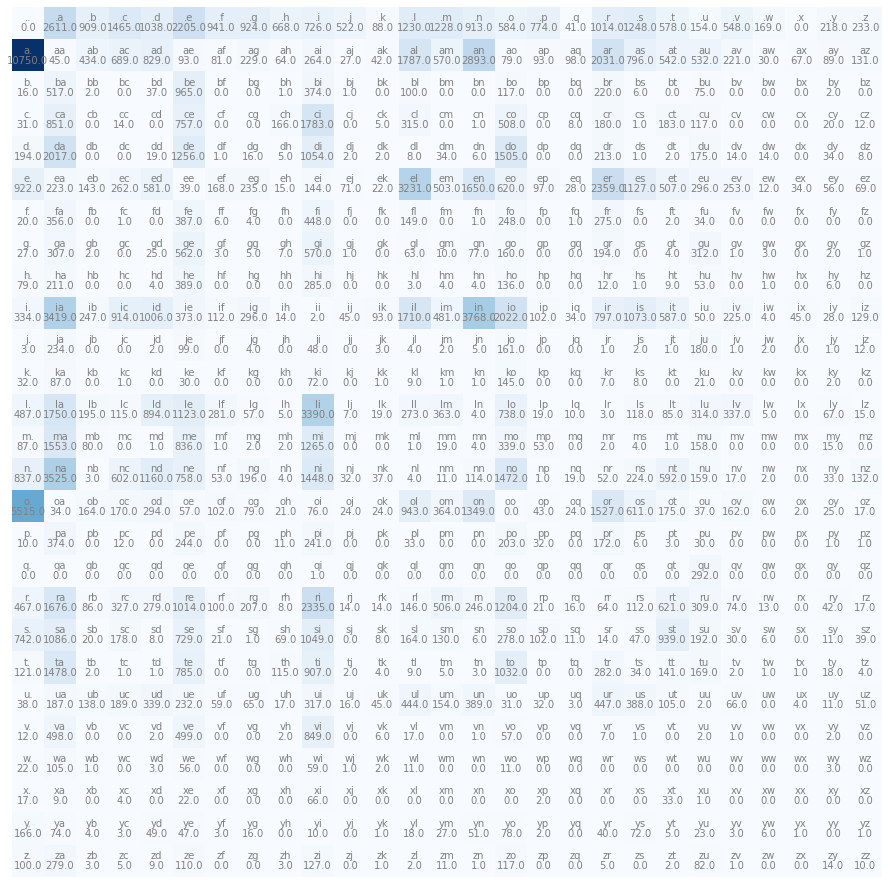

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    cts = fap[i] + fap[j]
    plt.text(j, i, cts, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off');

Hemos contado la ocurrencia de cada bigrama en el documento de nombres. Ahora, podemos utilizar este conteo como una distribución de probabilidades acerca de cuál letra debe ser consecutiva con otra. Ejemplifiquemos con una fila:

In [12]:
N[0]

tensor([   0., 2611.,  909., 1465., 1038., 2205.,  941.,  924.,  668.,  726.,
         522.,   88., 1230., 1228.,  913.,  584.,  774.,   41., 1014., 1248.,
         578.,  154.,  548.,  169.,    0.,  218.,  233.])

Obtendremos las probabilidades de cada valor al dividir cada uno por la sumatoria de los demás. Con este truco, todos los valores sumados entre sí nos darán 1:

In [13]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1242, 0.0432, 0.0697, 0.0494, 0.1049, 0.0447, 0.0439, 0.0318,
        0.0345, 0.0248, 0.0042, 0.0585, 0.0584, 0.0434, 0.0278, 0.0368, 0.0019,
        0.0482, 0.0593, 0.0275, 0.0073, 0.0261, 0.0080, 0.0000, 0.0104, 0.0111])

In [14]:
p.sum()

tensor(1.0000)

Ahora utilizaremos `torch.multinomial` para generar números enteros con base en las probabilidades de la distribución que creamos. Primero veamos un ejemplo:

In [15]:
p = torch.rand(3) #creamos tres valores aleatorios
print(p)
p = p / p.sum() # ahora, creamos una distribución de probabilidades con base en ellos
print(p)

tensor([0.7762, 0.0321, 0.0691])
tensor([0.8846, 0.0366, 0.0787])


In [16]:
torch.multinomial(p, num_samples=10, replacement=True) # ahora tomamos muestras de números enteros con base en la distribución
# Notemos que los números generados reflejan la distribución de probabilidades anteriores

tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

Podemos ejemplificar lo mismo con la primera fila de nuestra matriz:

In [17]:
p = N[0].float()
p = p / p.sum()

torch.multinomial(p, num_samples=5, replacement=True)

tensor([19,  5, 14,  4, 13])

Pero el resultado obtenido es el índice. Utilicemos nuestra tabla de consulta para obtener la letra correspondiente:

In [18]:
index = torch.multinomial(p, num_samples=1, replacement=True).item()
ejemplo = fap[index]
ejemplo

'g'

Ahora haremos lo mismo con todos los bigramas:

In [19]:
P = (N+1).float() # agregamos 1 al conteo para que el logaritmo no tenga problemas eventualmente (smoothing)
P /= P.sum(1, keepdim=True) # el 1 indica que la sumatoria se hace en la dimensión 1 (i. e., las columnas colapsan para sumarse)

In [20]:
P[0].sum(), P.shape

(tensor(1.0000), torch.Size([27, 27]))

Las probabilidades de nuestra primera fila lucen así:

In [21]:
P[0]

tensor([4.7492e-05, 1.2405e-01, 4.3218e-02, 6.9624e-02, 4.9345e-02, 1.0477e-01,
        4.4738e-02, 4.3930e-02, 3.1772e-02, 3.4527e-02, 2.4839e-02, 4.2268e-03,
        5.8463e-02, 5.8368e-02, 4.3408e-02, 2.7783e-02, 3.6807e-02, 1.9947e-03,
        4.8205e-02, 5.9318e-02, 2.7498e-02, 7.3613e-03, 2.6073e-02, 8.0737e-03,
        4.7492e-05, 1.0401e-02, 1.1113e-02])

Ahora que ya tenemos una probabilidad asignada a cada bigrama, podemos comenzar a predecir el carácter que debe acompañar a su precedente con base en nuestra matriz de probabilidades. Experimentemos con cinco palabras:

In [22]:
for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(fap[ix])
    if ix == 0:
      break
    
  print(''.join(out))

macito.
esaranartens.
milioredia.
hinitobal.
rinoreria.


Aunque quizá no elijamos ninguno de estos nombres para uso personal, podemos ver que el modelo funciona y ha generado palabras que de alguna forma reflejan la estructura del español.

También podemos observar las probabilidades asignadas a cada bigrama:

In [23]:
for p in palabras[:3]:
  cs = ['.'] + list(p) + ['.']
  for c1, c2 in zip(cs, cs[1:]):
    ix1 = paf[c1]
    ix2 = paf[c2] 
    prob = P[ix1, ix2]
    print(f'{c1}{c2}: {prob:.4f}') 

.m: 0.0584
ma: 0.3492
ar: 0.0863
ri: 0.2349
ia: 0.1907
a.: 0.4568
.r: 0.0482
ro: 0.1212
os: 0.0515
sa: 0.1840
a.: 0.4568
.j: 0.0248
jo: 0.2045
os: 0.0515
se: 0.1236
e.: 0.0674


Dado que altas probabilidades en nuestros bigramas indican buen «aprendizaje», en el sentido de que nuestro modelo no es completamente aleatorio, sino que concede importancia a bigramas apropiadamente, entonces podemos medir la «precisión» o capacidad de nuestro modelo mediante la función de verosimilitud (*likelihood*), que es el resultado de multiplicar todas las probabilidades entre sí. Si el número es alto, eso indicaría que nuestro modelo funciona bien; si es bajo, eso indicaría que no tiene suficiente información para predecir caracteres.

Por conveniencia, esta estimación utiliza el logaritmo natural de las probabilidades: sumar los logaritmos de las probabilidades es equivalente a multiplicar las probabilidades (es decir, podemos emplear cualquiera de las dos formas para estimar la verosimilitud). Esto es particularmente útil porque nuestras probabilidades están dadas en números decimales, de manera que multiplicarlas entre sí nos daría un número pequeño y poco intuitivo.

El logaritmo natural de una serie de números presenta como valor máximo al 0, pero como valor mínimo al infinito:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


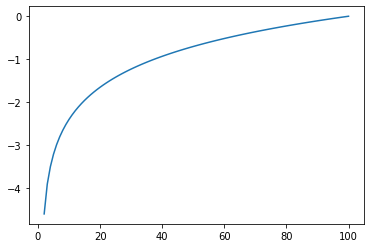

In [24]:
plt.plot(np.arange(1, 101, 1), np.log(np.arange(0, 1, 0.01)));

Pero, dado que quisiéramos números positivos para hacerlo más intuitivo, podemos volver positivo este número al multiplicarlo por -1:

In [25]:
logprob = torch.log(prob)
nlog = -logprob
f'Logaritmo natural de la probabilidad: {logprob} | Logaritmo natural negativo: {nlog}'

'Logaritmo natural de la probabilidad: -2.6970839500427246 | Logaritmo natural negativo: 2.6970839500427246'

Y el logaritmo negativo de la verosimilitud (*negative log likelihood*) es la suma de todos los logaritmos negativos. Nuestra función de pérdida[^1] entonces podría ser el logaritmo negativo de la verosimilitud (`nll`), normalizada para obtener el promedio. Mientras esta función de pérdida sea menor, nuestro modelo será mejor:

```{margin}
Matemáticamente, podemos formular esto como $-\log\left(p(X\mid\boldsymbol{\theta})\right) = -\log(p(x_1\mid\boldsymbol{\theta})) - \log(p(x_2\mid\boldsymbol{\theta})) \cdots - \log(p(x_n\mid\boldsymbol{\theta})) = -\sum_i \log(p(x_i \mid \theta)).$ Para saber más, véase [este capítulo](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html).
```

In [26]:
log_likelihood = 0.0
n = 0.0

for p in palabras:
  cs = ['.'] + list(p) + ['.']
  for c1, c2 in zip(cs, cs[1:]):
    ix1 = paf[c1]
    ix2 = paf[c2]
    prob = P[ix1,ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

nll = -log_likelihood
print(f'Logaritmo negativo de verosimilitud: {nll}')
print(f'Logaritmo negativo de verosimilitud promedio: {nll/n}')

Logaritmo negativo de verosimilitud: 375152.34375
Logaritmo negativo de verosimilitud promedio: 2.2672061920166016


In [27]:
log_likelihood = 0.0
n = 0.0

for bi in ['dante']:
  cs = ['.'] + list(bi) + ['.']
  for c1, c2 in zip(cs, cs[1:]):
    ix1 = paf[c1]
    ix2 = paf[c2]
    prob = P[ix1,ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    print(f'{c1}{c2} | prob: {prob:.7f} | logaritmo de la verosimilitud: {log_likelihood:.4f}')

nll = -log_likelihood
print(f'logaritmo negativo de la verosimilitud: {nll}')
print(f'promedio del logaritmo negativo: {nll/n}')

.d | prob: 0.0493446 | logaritmo de la verosimilitud: -3.0089
da | prob: 0.3054336 | logaritmo de la verosimilitud: -4.1949
an | prob: 0.1229762 | logaritmo de la verosimilitud: -6.2907
nt | prob: 0.0515025 | logaritmo de la verosimilitud: -9.2568
te | prob: 0.1527994 | logaritmo de la verosimilitud: -11.1355
e. | prob: 0.0674018 | logaritmo de la verosimilitud: -13.8326
logaritmo negativo de la verosimilitud: 13.832551956176758
promedio del logaritmo negativo: 2.3054254055023193


### Red neuronal

Ahora que tenemos una función de pérdida, podemos adaptar nuestro modelo a una red neuronal y optimizarlo. Crearemos bigramas de la misma manera, pero ahora crearemos un vector $x$ con el primer elemento del bigrama y otro $y$ con el segundo. Las $x$ serán entonces nuestras entradas y las $y$ nuestros objetivos:

In [28]:
# Juntaremos los bigramas para el set de entrenamiento (inputs x, objetivos y)
# Primero un ejemplo:

xs, ys = [], []

for p in palabras[:1]:
  cs = ['.'] + list(p) + ['.']
  for c1, c2 in zip(cs, cs[1:]):
    ix1 = paf[c1]
    ix2 = paf[c2]
    print(c1, c2)
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs, ys

. m
m a
a r
r i
i a
a .


(tensor([ 0, 13,  1, 18,  9,  1]), tensor([13,  1, 18,  9,  1,  0]))

In [29]:
# Ahora todas las palabras

xs, ys = [], []

for p in palabras:
  cs = ['.'] + list(p) + ['.']
  for c1, c2 in zip(cs, cs[1:]):
    ix1 = paf[c1]
    ix2 = paf[c2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs) # Pasamos cada bigrama a tensores x (inputs) e y (predicción deseada)
ys = torch.tensor(ys)
xs

tensor([ 0, 13,  1,  ..., 12, 12,  1])

Para pasar esta información a una red neuronal, primero la codificaremos (haremos un *encoding*) en vectores vía *one-hot encoding*, ya que este formato es más conveniente para una red neuronal. Esto significa que nuestros vectores tendrán 27 elementos, y todos serán de valor 0 salvo aquel que ocupe el lugar del carácter correspondiente, el cual será 1. 

Visualicemos, por ejemplo, el vector correspondiente a la letra «a», que se encuentra en la posición 1 de nuestro vocabulario (el punto `.` ocupa la posición 0):

In [30]:
import torch.nn.functional as F

# Primero veamos un ejemplo:
xenc = F.one_hot(xs[0:6], num_classes=27).float()
xenc[2]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

Podemos crear una visualización más gráfica de 6 vectores codificados. Como digo, la posición del 1 en cada vector indica el índice de la letra a la que corresponde:

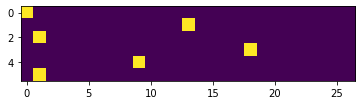

In [31]:
plt.imshow(xenc)

Ahora haremos lo mismo con todos los datos:

In [166]:
xenc = F.one_hot(xs, num_classes=27).float()
xenc, xenc.shape

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]]), torch.Size([165469, 27]))

Ahora crearemos una capa de neuronas (*i. e.,* una matriz de pesos, o sea, una *linear layer*)[^2], asignando pesos aleatorios a nuestro modelo para que se multipliquen con las entradas y se optimicen mediante la propagación hacia atrás. Más adelante explicaremos cómo eligiremos las dimensiones de la matriz de pesos.

Primero, procuremos entender cómo funcionará la multiplicación de nuestros vectores con la matriz de pesos. Ejemplifiquemos con los primeros tres vectores (o sea, los primeros tres caracteres) de nuestra incrustación:

In [167]:
w = torch.randn(27, 4)
xenc[:3].shape, w.shape

(torch.Size([3, 27]), torch.Size([27, 4]))

Nuestra matriz de pesos luce así:

In [168]:
w

tensor([[ 1.6804, -0.3333,  0.1523,  1.0912],
        [ 0.0711, -1.5924,  0.6650, -1.9040],
        [ 0.2606,  0.2247, -0.6540, -0.6477],
        [-0.4081, -2.2263, -0.6014, -1.3560],
        [ 1.3712,  0.4519,  1.1165,  0.4909],
        [ 0.5392, -0.9536, -0.5489,  0.5621],
        [-0.1191,  1.0517, -0.5388,  0.0509],
        [-0.2328,  0.5691, -0.1776, -0.8785],
        [-0.9944,  0.1690,  0.4808, -0.9270],
        [-1.9163, -0.4442, -0.8332,  0.2094],
        [-1.5595,  0.3131,  0.3176, -1.0424],
        [-0.8103,  0.0612, -0.3940, -0.6969],
        [ 1.6637,  0.1493,  0.2939,  0.4968],
        [ 0.8579, -0.4684, -0.5580, -0.5566],
        [-2.3027, -0.3928,  0.9376,  0.2877],
        [ 0.1478, -0.5560,  0.2106,  1.4563],
        [ 0.8955,  0.3372, -2.2538,  1.4221],
        [ 1.2976, -0.4296, -0.0524, -1.1490],
        [ 1.8105,  1.5439,  1.2894,  1.5108],
        [-0.9403, -1.0278, -1.1975, -1.4744],
        [-1.0490, -0.5257,  0.0466,  0.1303],
        [ 0.9318,  0.4428,  0.6996

Nuestra matriz de vectores:

In [169]:
xenc[:3]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Si multiplicamos ambas, obtenemos:

In [170]:
ejemplo = xenc[:3] @ w
ejemplo

tensor([[ 1.6804, -0.3333,  0.1523,  1.0912],
        [ 0.8579, -0.4684, -0.5580, -0.5566],
        [ 0.0711, -1.5924,  0.6650, -1.9040]])

El resultado de la multiplicación es una matriz con dimensiones 3x4. Para entender cómo se generó esta matriz, podemos tomar el primer vector de `xenc` y multiplicar cada uno de sus elementos por la primera columna de `w`. El primer vector luce así:

In [171]:
xenc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

De manera que al multiplicarlo por la primera columna, elemento por elemento (es decir, realizando una multiplicación Hadamard, denotada comúnmente por el signo $\odot$), obtenemos:

In [172]:
xenc[0] * w[:,0]

tensor([1.6804, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000])

Y la sumatoria de este vector claramente resulta:

In [173]:
(xenc[0] * w[:,0]).sum()

tensor(1.6804)

Que podemos observar en el primer valor de nuestra multiplicación de `xenc` con `w`:

In [174]:
ejemplo

tensor([[ 1.6804, -0.3333,  0.1523,  1.0912],
        [ 0.8579, -0.4684, -0.5580, -0.5566],
        [ 0.0711, -1.5924,  0.6650, -1.9040]])

Exactamente lo mismo, aunque de manera más eficiente, sucede cuando multiplicamos ambas matrices. En síntesis: al multiplicar nuestra matriz `w` por la matriz `xenc`, cada columna de pesos evalúa cada vector de `xenc`. Es decir, obtenemos una matriz de dimensiones 3x4 donde cada fila corresponde a cada vector (*i. e.*, cada carácter), pero esta fila tiene 4 valores correspondientes a la evaluación del vector por cada una de las columnas de la matriz `w`.

### Hacia la formulación de un modelo

Antes de programar nuestra red neuronal, detengámonos a entender lo que estamos haciendo: en primer lugar, podemos conceptualizar a una red neuronal como una función: nosotros esperamos que nos proporcione un resultado con base en las entradas que le suministremos:

<img src='https://miro.medium.com/max/640/1*sPg-0hha7o3iNPjY4n-vow.jpeg' width=400 class='center'>

Lo característico de esta función es que podemos entrenarla para que se configure a sí misma, es decir, la función encontrará (o «aprenderá») los parámetros necesarios para transformar las entradas que le proporcionemos en las salidas que queremos. En este caso particular, queremos que «transforme» una letra de entrada en otra de salida, y que realice este proceso hasta conseguir un nombre. La transformación que procuraremos a continuación será lineal y se realizará mediante la matriz de pesos `w`.

Antes, recapitulemos: hemos separado cada bigrama de nuestro conjunto de datos en tensores $\mathbf{x}$ e $\mathbf{y}$. El tensor $\mathbf{x}$ contiene las entradas, es decir, el primer carácter de cada bigrama que creamos por cada nombre que tenemos. El tensor $\mathbf{y}$ contiene el segundo carácter de cada uno de los bigramas. Utilizaremos $\mathbf{y}$ para entrenar al modelo e indicarle cuál carácter debe suceder a cualquier carácter dado de $\mathbf{x}$. Por ejemplo, si mi carácter de entrada a la red neuronal es «a», mi modelo podrá aprender que existen altas probabilidades de que esté acompañada por la letra «n»; después, partirá de «n» para generar el siguiente carácter y así sucesivamente hasta generar un nombre.

Pero para poder introducir nuestras letras en una red neuronal, debemos transformarlas en números con los que pueda operar. Para ello, codificamos nuestro tensor $\mathbf{x}$ vía vectores *one-hot* que, concatenados, constituyen la matriz `xenc`. A esta codificación —que equivale a $\mathbf{x}$ pero bajo una representación numérica basada en el índice de nuestra tabla de consulta— la multiplicamos por `w`, una capa lineal que evaluará nuestras entradas `xenc` por cada una de las neuronas que tenga.

Entonces, el resultado de esta multiplicación de matrices nos da un conteo de todos los caracteres de $\mathbf{x}$ —codificados en vectores—, evaluados por cada neurona de la capa lineal `w`. En ese sentido, este resultado es equivalente a la matriz `N` que graficamos anteriormente, aunque con un grado de complejidad mayor debido a las transformaciones numéricas que hemos realizado.

En realidad, lo que queremos hacer a continuación es entrenar nuestra red neuronal para que, con base en cada vector de entrada (de la matriz `xenc`), ese mismo vector sea transformado (mediante la multiplicación por los pesos) en probabilidades correspondientes a cada *token* que debería acompañarlo.

Manos a la obra: primero, crearemos una matriz `W` de dimensiones 27x27: necesitamos 27 filas para nuestros 27 *tokens* del vocabulario, y necesitamos 27 evaluaciones (columnas) para cada *token*. Estas evaluaciones tendrán que especificarnos las probabilidades asignadas a cada *token* de acompañar al *token* inicial evaluado.

In [175]:
W = torch.randn((27, 27), requires_grad=True) # Creamos weights aleatorios
logits = xenc @ W #multiplicamos valores de xenc por W para obtener log-counts
logits.shape

torch.Size([165469, 27])

Por lo pronto, nuestros valores son aleatorios y no han sido entrenados. Ahora, dado que nuestros `logits`[^3] tienen valores pequeños, negativos y positivos, queremos transformarlos para que puedan reflejar mejor la naturaleza de un «conteo» y nos faciliten su conversión en probabilidades. Para ello, únicamente necesitamos exponenciarlos, puesto que los números negativos terminarán en un rango del 0 al 1, y los positivos se convertirán en números mayores a 1. Visualicemos la función exponencial y después apliquémosla a nuestra matriz:

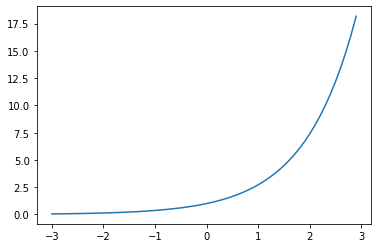

In [176]:
plt.plot(np.arange(-3, 3, 0.1), np.exp(np.arange(-3, 3, 0.1)));

In [177]:
counts = logits.exp() # exponenciamos para obtener valores mayores a 0, equivalentes a matriz N

Ahora, convertiremos nuestros conteos en probabilidades, dividiéndolos entre la sumatoria de todos los elementos de su fila correspondiente:

In [178]:
probs = counts / counts.sum(1, keepdims=True) # normalizar los counts para obtener probabilidades
probs # estos últimos dos pasos son equivalentes a la función softmax
probs.shape

torch.Size([165469, 27])

Ahora, nuestra primera fila contiene probabilidades que lucen así:

In [179]:
probs[0]

tensor([0.0096, 0.0704, 0.0243, 0.0560, 0.0687, 0.0090, 0.0270, 0.0457, 0.0506,
        0.0017, 0.0289, 0.0205, 0.0080, 0.0471, 0.0213, 0.0887, 0.0838, 0.0318,
        0.0142, 0.0524, 0.0047, 0.0464, 0.0985, 0.0197, 0.0227, 0.0201, 0.0283],
       grad_fn=<SelectBackward0>)

Antes de continuar, podemos visualizar el arreglo de información que tenemos. Tomemos como base nuestro primer nombre («María», que ha quedado ajustado a «.maria.»):

In [180]:
nlls = torch.zeros(6)
for i in range(6):
  x = xs[i].item()
  y = ys[i].item()
  print('-----------')
  print(f'Bigrama ejemplo {i+1}: {fap[x]}{fap[y]}, índices {x},{y}')
  print(f'Input: {x}')
  print(f'Probabilidades de cada output calculadas por la red neuronal: {probs[i]}')
  print(f'Output correcto: {y}')
  p = probs[i, y]
  print(f'Probabilidad asignada por la red neuronal al carácter correcto: {p.item()}')
  logp = torch.log(p)
  print('Logaritmo de la verosimilitud', logp.item())
  nll = -logp
  print('Logaritmo negativo de la verosimilitud:', nll.item())
  nlls[i] = nll

print('----------')
print(f'Promedio de la nll, i. e. pérdida total = {nlls.mean().item()}')

-----------
Bigrama ejemplo 1: .m, índices 0,13
Input: 0
Probabilidades de cada output calculadas por la red neuronal: tensor([0.0096, 0.0704, 0.0243, 0.0560, 0.0687, 0.0090, 0.0270, 0.0457, 0.0506,
        0.0017, 0.0289, 0.0205, 0.0080, 0.0471, 0.0213, 0.0887, 0.0838, 0.0318,
        0.0142, 0.0524, 0.0047, 0.0464, 0.0985, 0.0197, 0.0227, 0.0201, 0.0283],
       grad_fn=<SelectBackward0>)
Output correcto: 13
Probabilidad asignada por la red neuronal al carácter correcto: 0.04705430194735527
Logaritmo de la verosimilitud -3.056452989578247
Logaritmo negativo de la verosimilitud: 3.056452989578247
-----------
Bigrama ejemplo 2: ma, índices 13,1
Input: 13
Probabilidades de cada output calculadas por la red neuronal: tensor([0.0171, 0.0113, 0.0380, 0.0324, 0.0241, 0.0180, 0.0223, 0.0269, 0.0354,
        0.0124, 0.0092, 0.0323, 0.0372, 0.0657, 0.1751, 0.0092, 0.0080, 0.1024,
        0.0069, 0.0092, 0.0266, 0.0315, 0.0494, 0.0146, 0.1493, 0.0156, 0.0198],
       grad_fn=<SelectBackward0>)


Bien, tenemos los 6 bigramas del nombre, el índice de cada input y output de cada bigrama, etcétera. Ahora, queremos ajustar nuestro modelo para que, con base en la pérdida de cada bigrama —medida por el logaritmo negativo de la verosimilitud, igual que anteriormente—, optimicemos los pesos de la matriz `W` de tal forma que, al multiplicarla por cada vector input (`xenc`), nos devuelva otro vector con probabilidades asignadas a cada carácter que puede suceder el carácter en cuestión, pero con probabilidad alta asignada al carácter que debe acompañarlo.

Tomemos en cuenta que todas las operaciones que hemos realizado hasta ahora son diferenciables (se pueden derivar). Ahora, para poder programar una función de pérdida que entrene todos nuestros términos, ejemplifiquemos también con nuestro primer nombre:

In [181]:
xs[:6]

tensor([ 0, 13,  1, 18,  9,  1])

In [182]:
ys[:6]

tensor([13,  1, 18,  9,  1,  0])

Obtenemos el índice de cada bigrama en nuestros tensores `x` e `y` y, con base en ellos, rastreamos la probabilidad asignada a `y` dado `x`:

In [183]:
probs[0,13], probs[1,1], probs[2,18], probs[3,9], probs[4,1], probs[5,0]

(tensor(0.0471, grad_fn=<SelectBackward0>),
 tensor(0.0113, grad_fn=<SelectBackward0>),
 tensor(0.0453, grad_fn=<SelectBackward0>),
 tensor(0.0451, grad_fn=<SelectBackward0>),
 tensor(0.0301, grad_fn=<SelectBackward0>),
 tensor(0.0121, grad_fn=<SelectBackward0>))

Que sería equivalente a hacer algo como:

In [184]:
probs[torch.arange(6), ys[:6]]

tensor([0.0471, 0.0113, 0.0453, 0.0451, 0.0301, 0.0121],
       grad_fn=<IndexBackward0>)

Y para obtener el promedio general del logaritmo negativo de la verosimilitud, únicamente agregamos:

In [185]:
-probs[torch.arange(6), ys[:6]].log().mean()

tensor(3.6074, grad_fn=<NegBackward0>)

Finalmente, agregaremos un componente de regularización —el cual explicaremos en otra ocasión, aunque de momento se puede visualizar [este video](https://youtu.be/EehRcPo1M-Q)— a nuestra pérdida. Ahora ya podemos entrenar nuestro modelo:

In [186]:
num = xs.nelement()
losses = []

# FORWARD PASS
for i in range(50):
  xenc = F.one_hot(xs, num_classes=27).float() # one-hot encoding
  logits = xenc @ W #multiplicamos valores de x por w para obtener logits
  counts = logits.exp() # exponenciamos para obtener valores mayores a 0, equivalentes a matriz N
  probs = counts / counts.sum(1, keepdims=True) # normalizar los conteos para obtener probabilidades
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # creamos función de pérdida (este último término es la regularización) 
  
  # BACKWARD PASS
  W.grad = None # equivalente a reiniciar los gradientes a 0
  loss.backward() # propagación hacia atrás
  losses.append(loss.item())
  if i % 5 == 0:
    print(f"step: [{i:>02d}]   loss={loss:.6f}")

  # UPDATE
  W.data += -50 * W.grad # actualizamos los valores de W con base en sus gradientes

step: [00]   loss=3.806062
step: [05]   loss=2.672217
step: [10]   loss=2.497344
step: [15]   loss=2.428483
step: [20]   loss=2.393344
step: [25]   loss=2.371606
step: [30]   loss=2.356778
step: [35]   loss=2.346093
step: [40]   loss=2.338058
step: [45]   loss=2.331840


Podemos visualizar nuestra pérdida a lo largo del entrenamiento:

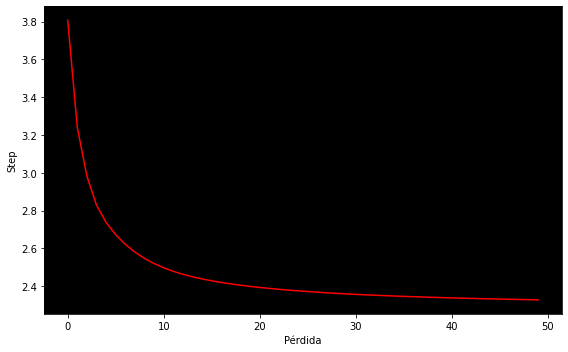

In [187]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(losses, color='red') 
ax.set_facecolor('black')
ax.set_xlabel('Pérdida')
ax.set_ylabel('Step')
plt.tight_layout();

Nuestra distribución de probabilidades para cada carácter ahora luce así (por detalles técnicos, debemos leer «.» en lugar de «`»):

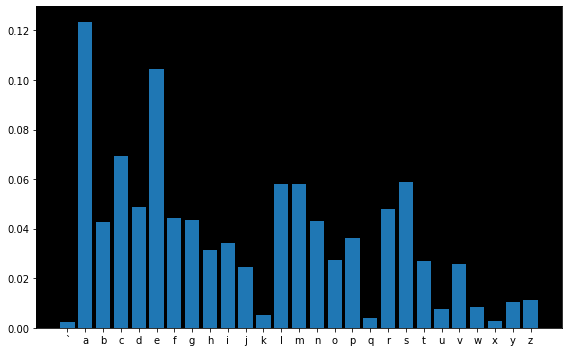

In [188]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(list(map(chr, range(96, 123))), probs[0].data) 
ax.set_facecolor('black')
plt.tight_layout();

Una vez entrenado el modelo, podemos obtener muestras con base en él:

In [210]:
for i in range(10):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdims=True).item()

    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(fap[ix])

    if ix == 0:
      break

  print(''.join(out))

a.
o.
r.
osama.
dan.
iolidenarteceliugialdeminalbqs.
cin.
limo.
enima.
cincejumiliva.


Finalmente, comparemos las matrices entrenadas de ambos métodos:

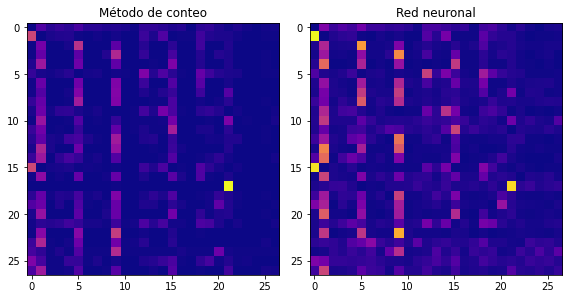

In [211]:
W_exp = W.exp()
P_nn = W_exp / W_exp.sum(dim=1, keepdim=True)
P_nn.shape

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(P.data, cmap='plasma')
ax[0].set_title("Método de conteo")
ax[1].imshow(P_nn.data, cmap='plasma')
ax[1].set_title("Red neuronal")
plt.tight_layout();

Aunque nuestro modelo de red neuronal no haya superado al de simple conteo y probabilidad, puesto que en realidad los implementamos de tal manera que son prácticamente iguales, lo cierto es que esta estructura de red neuronal contiene ya los rudimentos esenciales para superar con creces al modelo anterior. En realidad, una implementación más compleja y óptima de nuestra red neuronal solo consistirá en cambiar la manera en que lidiamos con los datos (nuestro vocabulario, *tokens*, tabla de consulta, `xenc`, por ejemplo) y con las capas de neuronas (nuestra `W`, por ejemplo). Todo lo demás permanecerá igual. En la próxima lección profundizaremos en esto.

[^1]: La función de pérdida siempre dependerá de la naturaleza del problema. Dado que este es un problema de clasificación relacionado con probabilidades, hemos elegido una función apta. Durante la implementación de `pequegrad`, habíamos empleado la regresión lineal.

[^2]: Comúnmente se denomina capa lineal o *lineal layer* a la serie de pesos y/o sesgos que creamos para multiplicarlos y sumarlos por nuestras entradas. Como hemos visto, tanto la función multiplicación como la función suma siempre resultan una línea recta en el plano cartesiano, y de ahí el adjetivo «lineal». Estamos transformando linealmente nuestras entradas, puesto que la graficación de la multiplicación y la suma con los pesos y sesgos es una línea.

[^3]: Hemos denominado «logit» al resultado de nuestra multiplicación de matrices, sin embargo, en el ámbito del *deep learning*, el término «logit» puede llegar a ser [bastante ambiguo](https://stackoverflow.com/a/50511692/19440446). En nuestro caso, denominamos así a nuestra matriz porque es la última (y única) capa de la red neuronal, y está representando un conteo en bruto de la ocurrencia de cada $x$ que luego utilizaremos para convertir en probabilidades. Aunque nuestra explicación también sea insatisfactoria, debemos conformarnos con ella por el momento. La ambigüedad del término es tal que su misma composición es extraña: no está prefijado con base en «logaritmo», sino en «logístico», pues es una abreviación de «unidad logística» (*logistic unit*); pero nunca ha estado clara la razón detrás del término «logístico» en matemáticas y, para más inri, el uso de «logit» en *deep learning* no siempre tiene un fundamento matemático riguroso. En fin, no nos perdamos entre las ramas y volvamos a lo nuestro.

### Bibliografía recomendada

**zhang2021dive** Zhang, Aston; Lipton, Zachary C.; Li, Mu y Smola, Alexander J. *Dive into Deep Learning* (cap. 15), 2021. [URL](https://d2l.ai/chapter_natural-language-processing-pretraining/index.html).

**voita2020nlpCourse** Voita, Elena. *NLP Course For You*, 2020. [URL](https://lena-voita.github.io/nlp_course.html).